In [3]:
import cv2 

img = cv2.imread(r'C:\Users\oem\Downloads\perro.jpg')
print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

648 486 3 3


# Convolutional Neural Networks

# Importar Librerías

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [3]:
dirname = r'C:\Users\oem\Downloads\IANOT\datasetreco'
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
C:\Users\oem\AppData\Local\Temp\ipykernel_20148\2866201859.py:14: SyntaxWarning: invalid escape sequence '\.'
  if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):


leyendo imagenes de  C:\Users\oem\Downloads\IANOT\datasetreco\
C:\Users\oem\Downloads\IANOT\datasetreco\ant 1
C:\Users\oem\Downloads\IANOT\datasetreco\cat 2720
C:\Users\oem\Downloads\IANOT\datasetreco\dog 2400
C:\Users\oem\Downloads\IANOT\datasetreco\ladybug 4993
C:\Users\oem\Downloads\IANOT\datasetreco\turtle 4843
Directorios leidos: 5
Imagenes en cada directorio [2721, 2400, 4993, 4843, 8619]
suma Total de imagenes en subdirs: 23576


# Creamos las etiquetas

In [4]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  23576


In [5]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 ant
1 cat
2 dog
3 ladybug
4 turtle


In [6]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [7]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (18860, 224, 224, 3) (18860,)
Testing data shape :  (4716, 224, 224, 3) (4716,)


Text(0.5, 1.0, 'Ground Truth : 3')

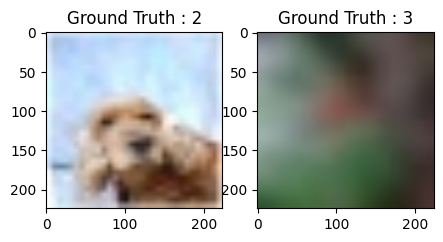

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

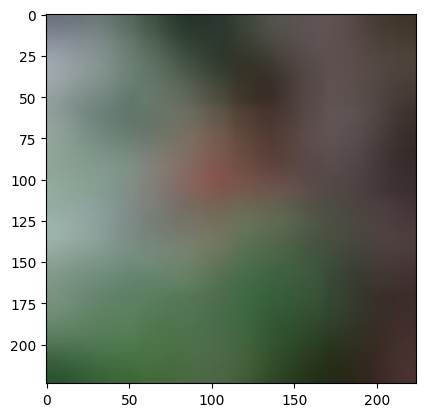

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [10]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [11]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [12]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(15088, 224, 224, 3) (3772, 224, 224, 3) (15088, 5) (3772, 5)


# Creamos el modelo de CNN

In [13]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [14]:
sport_model = Sequential()
# Cambiamos (21, 28, 3) por (224, 224, 3)
sport_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=(224, 224, 3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))


sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

c:\Users\oem\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\oem\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [15]:
sport_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │    12,845,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,846,149 (49.00 MB)

 Trainable params: 12,846,149 (49.00 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Opción A: La forma más directa (Eliminando .legacy y el decay antiguo)
sport_model.compile(
    loss=keras.losses.categorical_crossentropy, 
    optimizer=tf.keras.optimizers.SGD(learning_rate=INIT_LR), 
    metrics=['accuracy']
)




# Entrenamos el modelo: Aprende a clasificar imágenes

In [17]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 108s 452ms/step - accuracy: 0.5152 - loss: 1.2009 - val_accuracy: 0.6068 - val_loss: 1.0314
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 99s 415ms/step - accuracy: 0.5876 - loss: 1.0446 - val_accuracy: 0.6124 - val_loss: 0.9931
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 96s 408ms/step - accuracy: 0.5967 - loss: 1.0159 - val_accuracy: 0.6275 - val_loss: 0.9639
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 97s 412ms/step - accuracy: 0.6096 - loss: 0.9952 - val_accuracy: 0.6249 - val_loss: 0.9507
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 98s 415ms/step - accuracy: 0.6165 - loss: 0.9827 - val_accuracy: 0.6336 - val_loss: 0.9320
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 96s 408ms/step - accuracy: 0.6176 - loss: 0.9741 - val_accuracy: 0.6352 - val_loss: 0.9283
Epoch 7/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 96s 408ms/step - accuracy: 0.6206 - loss: 0.9615 - val_accuracy: 0.6357 - val_loss: 0.9200
Epoch 8/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 96s 407ms/step - accuracy: 0.6247 - loss: 

In [18]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save(r"C:\Users\oem\Downloads\IANOT\sport.h5")

# Evaluamos la red

In [19]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6635 - loss: 0.8394


In [20]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.8393710255622864
Test accuracy: 0.6634860038757324


In [21]:
sport_train.history

{'accuracy': [0.5151776075363159,
  0.5876193046569824,
  0.5966993570327759,
  0.6096235513687134,
  0.6165164113044739,
  0.6176431775093079,
  0.6206256747245789,
  0.6246685981750488,
  0.6233430504798889,
  0.627982497215271,
  0.6273197531700134,
  0.6330859065055847,
  0.6334173083305359,
  0.6365986466407776,
  0.635869562625885,
  0.6316940784454346,
  0.639912486076355,
  0.6407078504562378,
  0.6422985196113586,
  0.6475344896316528],
 'loss': [1.2008564472198486,
  1.044648289680481,
  1.0159196853637695,
  0.9952095746994019,
  0.9827215075492859,
  0.97413569688797,
  0.9615216255187988,
  0.9493991732597351,
  0.9423725605010986,
  0.9410471320152283,
  0.931246817111969,
  0.9246938228607178,
  0.921459972858429,
  0.9182924628257751,
  0.9101168513298035,
  0.9104570746421814,
  0.9002158641815186,
  0.8974785208702087,
  0.8965299129486084,
  0.8863934278488159],
 'val_accuracy': [0.6068398952484131,
  0.6124072074890137,
  0.6275185346603394,
  0.6248674392700195,
  

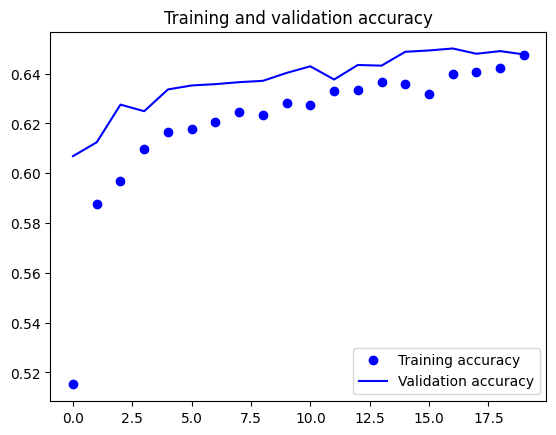

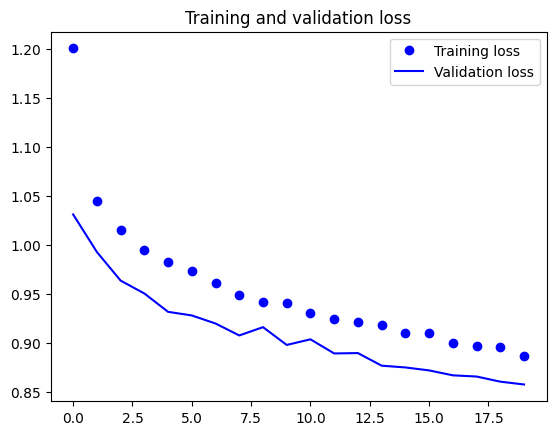

In [22]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
predicted_classes2 = sport_model.predict(test_X)

148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step


In [24]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [25]:
predicted_classes.shape, test_Y.shape

((4716,), (4716,))

# Aprendamos de los errores: Qué mejorar

Found 3129 correct labels


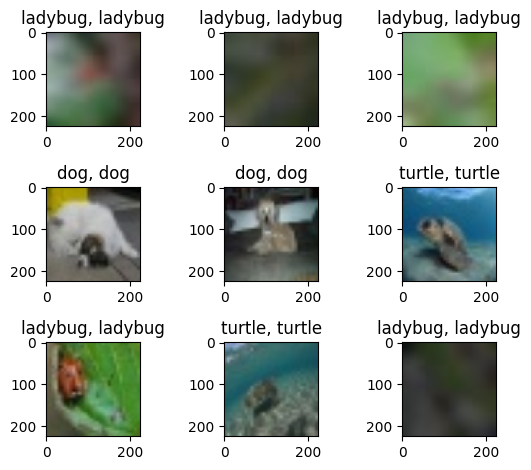

In [26]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(224,224,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 1587 incorrect labels


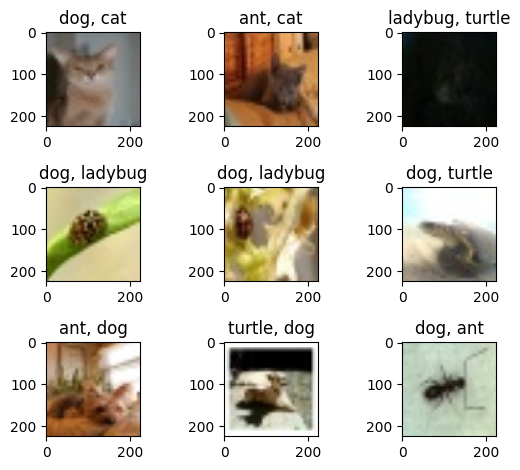

In [27]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(224,224,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [28]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.31      0.04      0.06       525
     Class 1       0.13      0.01      0.01       464
     Class 2       0.45      0.87      0.59      1052
     Class 3       0.64      0.61      0.62       947
     Class 4       0.95      0.94      0.95      1728

    accuracy                           0.66      4716
   macro avg       0.50      0.49      0.45      4716
weighted avg       0.63      0.66      0.61      4716



In [3]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = [r'C:\Users\oem\Downloads\tortuga.png']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (224, 224),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

NameError: name 'sport_model' is not defined

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lista de nombres de tus clases (Asegúrate que coincidan con el orden alfabético de tus carpetas)
# 0:Gatos, 1:Hormigas, 2:Mariquitas, 3:Perros, 4:Tortugas
nombres_clases = ['Hormiga', 'Gato', 'Perro', 'Mariquita', 'Tortuga']

# 1. Pon aquí la ruta de la imagen que quieres probar
path_imagen = r'C:\Users\oem\Downloads\sea.jpg'  # <--- Cambia esto por tu foto

# 2. Leer igual que en el entrenamiento (con OpenCV)
img = cv2.imread(path_imagen)

if img is None:
    print("❌ Error: No se encontró la imagen. Revisa la ruta.")
else:
    # 3. Redimensionar a 224x224 (sin deformar si usas tu función padding, o directo si no)
    # Aquí lo hacemos directo para probar rápido:
    img_resized = cv2.resize(img, (224, 224))
    
    # 4. Convertir a formato que espera el modelo
    # El modelo espera una lista de imágenes, así que añadimos una dimensión extra
    # Shape actual: (224, 224, 3) -> Shape nuevo: (1, 224, 224, 3)
    img_array = np.expand_dims(img_resized, axis=0)
    
    # 5. Normalizar (SOLO si entrenaste dividiendo entre 255)
    # Como cv2 lee de 0 a 255, aquí sí dividimos.
    img_array = img_array.astype('float32') / 255.0

    # 6. Predecir
    prediccion = sport_model.predict(img_array)
    indice_ganador = np.argmax(prediccion)
    probabilidad = np.max(prediccion) * 100

    # Mostrar resultado
    print(f"\n🧠 La IA dice: {nombres_clases[indice_ganador]}")
    print(f"📊 Seguridad: {probabilidad:.2f}%")

    # Mostrar la imagen para que veas qué analizó (Convertimos BGR a RGB solo para mostrar)
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicción: {nombres_clases[indice_ganador]}")
    plt.axis('off')
    plt.show()

NameError: name 'sport_model' is not defined